In [56]:
import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

In [57]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

# Img_in

Tub does exist
Predicted steering angle: 0.1428571428571428 - Actual: 0.039605


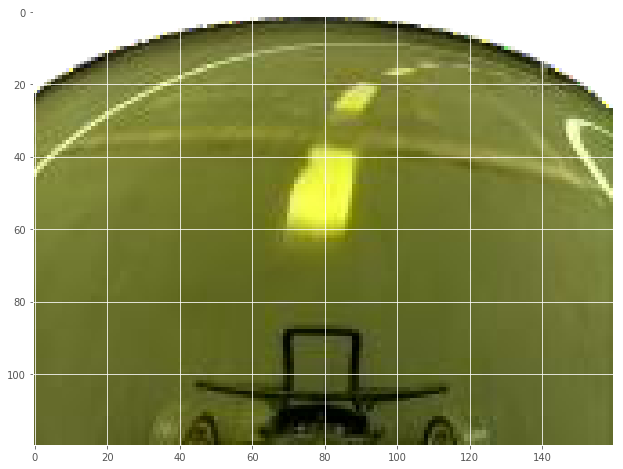

In [66]:
model = keras.models.load_model('../../donkeycar/d2/models/oak')
dataset = dataset_from_all_tubs('../../donkeycar/d2/data.oakland.golden')
predicted, actual = output_pair_cat(model, dataset)
i = 200
print("Predicted steering angle: {} - Actual: {}".format(predicted[i], actual[i]))
img_in = dataset[0][[i]]
plt.imshow(img_in[0])

# Grad-CAM heatmap

In [67]:
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.python.framework import ops
import keras.backend as K
import datetime
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
import os
import tempfile
import shutil
from subprocess import call

import donkeycar as dk

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(img_path):
    img = image.load_img(img_path, target_size=(120, 160))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_5'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = load_model(modelpath)
    return new_model

functions = {}

def grad_cam(input_model, image, category_index, layer_name):
    model = input_model
    nb_classes = 15
    f = None

    if category_index in functions:
        f = functions[category_index]
    else:
        loss = model.output[0][:, category_index]
        conv_output = model.get_layer(layer_name).output
        grads = normalize(K.gradients(loss, conv_output)[0])
        f = K.function([model.input, K.learning_phase()], [conv_output, grads])
        functions[category_index] = f

    output, grads_val = f([image, 1])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (160, 120))
    cam = np.maximum(cam, 1)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    #image += 0.5
    #image *= 255
    #image -= np.min(image)
    #image = np.minimum(image, 255)

    cam = mix_heatmap(image, heatmap)
    return cam, heatmap


def mix_heatmap(img, heatmap):
    if len(img.shape) > 3:
        img = img[0]
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_HOT)
    cam = np.float32(cam) + np.float32(img)
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    return cam

def overlay_gradcam(img_in, model):
    img_in = img_in.reshape((1,) + img_in.shape)
    predicted_angle, _ = model.predict(img_in)
    predicted_class = np.argmax(predicted_angle[0])
    cam, heatmap = grad_cam(model, img_in, predicted_class, 'conv2d_5')
    from IPython.core.debugger import set_trace
    set_trace()
    img =  mix_heatmap(img_in, heatmap)
    return img

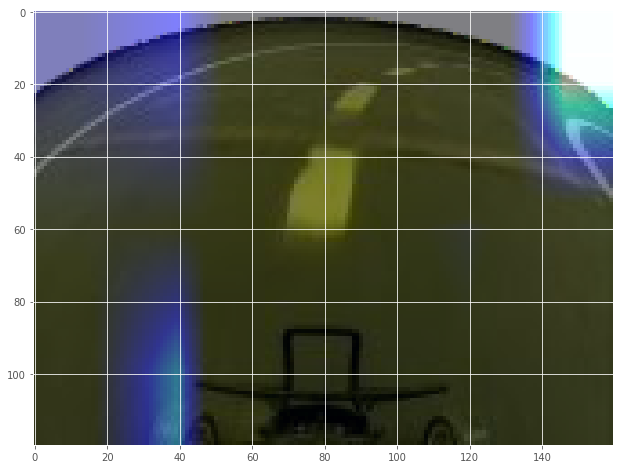

In [68]:
predicted_angle, _ = model.predict(img_in)
predicted_class = np.argmax(predicted_angle[0])
cam, heatmap = grad_cam(model, img_in, predicted_class, 'conv2d_5')
plt.imshow(cam)

# Guided Saliency Objects

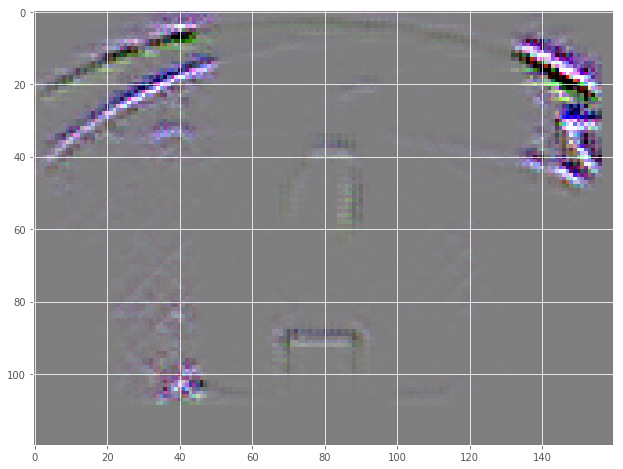

In [69]:
modelpath = '../../donkeycar/d2/models/oak'

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([img_in, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
plt.imshow(deprocess_image(gradcam))

# 1st Conv layer activation tiles

In [70]:
import keras.backend as K
import math


def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

def activation_tiles(model, img_in, layer_index):
    activation = get_activations(model, img_in, print_shape_only=True)[layer_index][0]
    activation = np.transpose(activation, (2, 0, 1))

    rows = math.ceil(len(activation)/8)
    fig, subplts = plt.subplots(rows,8)

    for i in range(rows):
        for j in range(8):
            subplt = subplts[i][j]
            subplt.axis('off')
            subplt.imshow(activation[i*6+j], interpolation='None', cmap='hot')

----- activations -----
(1, 120, 160, 3)
(1, 58, 78, 24)
(1, 27, 37, 32)
(1, 12, 17, 64)
(1, 5, 8, 64)
(1, 3, 6, 64)
(1, 1152)
(1, 100)
(1, 100)
(1, 50)
(1, 50)
(1, 15)
(1, 1)


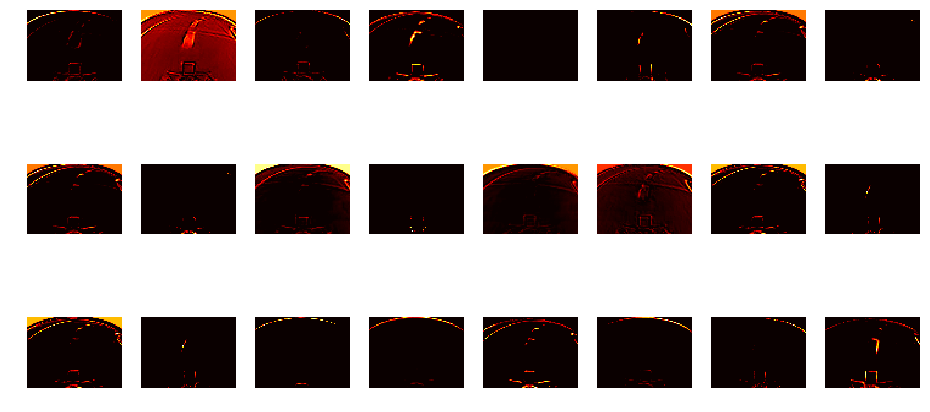

In [71]:
activation_tiles(model, img_in, 1)

# 1st Conv layer filter weights

*Question: these filters don't seem to be visually identifiable. Does it mean we need a bigger kernel (7x7, 11x11)?

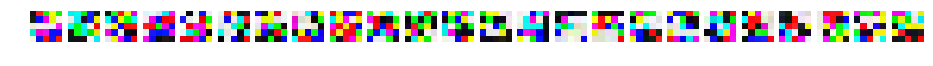

In [64]:
fl1 = model.layers[1].get_weights()[0]
fl1 = np.transpose(fl1, (3, 0, 1, 2))
fl1.shape
fig, subplts = plt.subplots(1,24)
for i, subplt in enumerate(subplts):
    subplt.axis('off')
    subplt.imshow(fl1[i])
# plt.imshow(fl1[0])